In [1]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Week 4 - Embeddings for Recommendation 

Here we'll see how to train our simple **Dot Product** model, along with our **user embeddings** and **item embeddings** using the **Keras** library. As before, we'll be checking out the **MovieLens** dataset 

## Loading in the Dataset

First we load in the small version of the dataset. As this is a **Collaborative Filtering** approach, we are interested in the **ratings.csv**, which has all over ratings made by each user.

In [2]:
df = pd.read_csv("ml-latest-small/ratings.csv")

In [3]:
len(df)

100004

In [4]:
df.tail(10)

,userId,movieId,rating,timestamp
99994,671,5952,5.0,1063502716
99995,671,5989,4.0,1064890625
99996,671,5991,4.5,1064245387
99997,671,5995,4.0,1066793014
99998,671,6212,2.5,1065149436
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


## Preprocessing 

What we have in the dataset is a list of **userId** and **movieId** pairs loaded into a ``Pandas`` DataFrame. 

As we said before, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

When we make the embedding, we will need a way of mapping back from **indexes** in the **one-hot encoding** back to the ids for the users and movies. 

### Vocabulary 

In order to make the vocabulary (all the unique ids), we can use the ``unique()`` function in ``Pandas``

In [5]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [6]:
len(movie_ids)

9066

In [7]:
#Non-sequential list of ids
movie_ids[:6]

[31, 1029, 1061, 1129, 1172, 1263]

### Dictionary Comprehensions 

We've seen ``Dictionaries`` (e.g. when looking at JSON from REST APIs). This is a collection like a ``List``, but instead of using indexes to access data (**values**), we use **keys**. 

We've also seen ``List Comprehensions``, a short hand way to iterate through an existing collection and make a new ``List``. 

As we want something where we can use an arbitrary string/number (e.g. a movie or user id) to look up an index, a ``Dictionary`` seems like a good data structure to use. We can declare dictionaries manually (see below), but it would be much quicker and cleaner to use the information we already have to make this.


In [8]:
#Manually making the dictionary
movie_id_to_index = {
    31: 1,
    1029: 2,
    1061: 3
}
#Use a movie id to look up an index
movie_id_to_index[31]

1

Like the ``List Comprehension``, the ``Dictionary Comprehension`` iterates through a given collection, does some calculation and stores new values in a new collection. 

In this case, we need to return both a ``Key`` and a ``Value`` for each item. 

```
a = [1,2,3]
b = {i:i+1 for i in a} 
```

is the same as 

```
a = [1,2,3]
b = {}
for i in a:
    b[i] = i+1
```

where we end up with the ``Dictionary``

```
{
    1: 2,
    2: 3,
    3: 4
}
```

Below, we combine the dictionary comprehension with the ``enumerate()`` function to return the id (x) and the index (i) and store them in a new dictionary 

In [9]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [10]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [11]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


### Scaling the ratings

As is good when working with ``gradient descent``, it helps to have our values on a similar range, and for that to be between 0 and 1. We can use the ``MinMaxScaler`` from ``Scikit-Learn`` to scale our ratings to between 0 and 1

In [12]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [13]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [14]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

## Training Set

We are making a **predictive model** that will take a **user** and **movie** and return a **rating**. 

For our training, we will make a dataset using the information we already know. In this context, our input feautres (``x``) are the movie and user indexes, and the our output (``y``) is the rating. 

We make a train - test split of ``10%`` to validate our model. 

In [15]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Making a Custom Model 

Previously in ``Keras`` we have used to pre-existing layers, connecting them all together in using the [Sequential](https://keras.io/guides/sequential_model/) object. This allows us to fit together layers that pass information forwards in a structure that works for most **Neural Networks**.

``Keras`` also has a [Model](https://keras.io/api/models/model/) object which we can **subclass**. Without getting too bogged down in the details of **Object Oriented Programming**, essentially what this means is we can take the **existing functionality** from this object and **override** certain functions to add in custom behaviour.

Using the ``Model`` structure, we have something that can take advantage of a lot the things that are built into the ``Keras`` library. It can be trained, can have layers, can have parameters that can be optimised.

**But**, we can also add in our own functionality. 

The two main functions we want to override and these are 

1. ``def __init__()``
    
    * This is called **once** when the object is first made. We can use this to define our layers 
    

2. ``def call()``

    * This is called everytime we want to make a forwards pass. This means it takes some **inputs** and returns some **outputs**. This is called during training, or for inference on a trained model. 
    
### LouisNet

Below, we show an **incredibly simple model**, but it should help you get an intuition for what function is called at when in the training process

We can see the ``__init__()`` is called once, and then the ``call()`` is called **once per batch**, where we get the inputs for this batch and return some outputs

This model doesnt actually have any parameters to train, its more to demonstrate the subclassing principle in the simplest terms

In [18]:
#Define class and subclass keras.Model
class LouisNet(keras.Model):
    
    #Override __init__()
    def __init__(self, **kwargs):
        super(LouisNet, self).__init__(**kwargs)
        print("__init__ called")
    
    #Override call()
    def call(self, inputs):
        tf.print("\nforwards pass (new batch)")
        tf.print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
louisNet.compile(loss="mse")
#Train
louisNet.fit(
    x=[[1],[2],[3],[4]],
    y=[[5],[6],[7],[8]],
    epochs=2,
    batch_size=2
)

__init__ called
Epoch 1/2

forwards pass (new batch)
[[1]
 [4]] 

1/2 [==============>...............] - ETA: 0s - loss: 16.0000
forwards pass (new batch)
[[3]
 [2]] 

2/2 [==============================] - 0s 6ms/step - loss: 16.0000
Epoch 2/2

forwards pass (new batch)
[[3]
 [1]] 

1/2 [==============>...............] - ETA: 0s - loss: 16.0000
forwards pass (new batch)
[[4]
 [2]] 

2/2 [==============================] - 0s 7ms/step - loss: 16.0000


## The Dot Product Recommender Model

Lets remember the model we're trying to make. 


```
Predicted Rating = Dot Product(user_vector, item_vector) + user_bias + item_bias
```


Our target is to find a vector for each movie and user so that their dot product (+ their biases) is an accurate prediction for the rating that user would make for that movie. 

Each of these vectors will be contained in a matrix, that we call an **embedding**


### The Embedding Layer 

Again, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

Luckily, ```Keras``` has a layer already we can use, all we have to say is 

1. How many items we have (vocabulary size)

2. The size of the embedding 

You might use something between 10-300, and this is something you will have to tune

### New Arguments for ``__init__``

Again, we will override the ```__init__()``` function, but this time we will add in some extra arguments. We can use this to pass in 

1. Number of users 

2. Number of movies

3. Size of Embedding

These get passed in when we make the new object 

```
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

```

### Saving Variables and ```self```

Finally, the last **Object-oriented** concept we'll need allows us to save things within the object. These are sometimes called ``instance variables`` or ``fields``, but the main thing you need to know is **these are like the variables we use all the time to store objects and data**, apart from they belong to the object, and only work within this context 

We use the keyword ```self``` within the object to refer to itself. We can use this to make layers in the ```__init__()``` function, store them in the object, and then reuse and update them in the ```call()``` function.


In [19]:
#Define the new class
class RecommenderNet(keras.Model):
    
    #Override init with new arguments 
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Make an embedding layer for users
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for user bias
        self.user_bias = layers.Embedding(num_users, 1)
        #Make an embedding layer for movies
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for movie bias
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        #inputs contains [[user,movie],[user,movie],[user,movie]...]
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        #Dot product 
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

### Train 

Now we can ```compile()``` and ```fit()``` just like we would any model. 


On every forwards pass (see ``call()`` above)

1. We take a batch of ``users`` and ``movies``


2. Run them through the normal embedding and bias embedding layers respectively 


3. Get the vectors for each out 


4. Get the dot product of the user and movie vectors 


5. Add the biases 


6. Run through a sigmoid


7. Return!

In [20]:
#Pick Embedding size
EMBEDDING_SIZE = 20
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.001)
)


C:\Users\Crys\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
#TRAIN
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_test, y_test)
)

Epoch 1/20
1407/1407 [==============================] - 6s 3ms/step - loss: 0.0581 - val_loss: 0.0477
Epoch 2/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0450 - val_loss: 0.0447
Epoch 3/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0421 - val_loss: 0.0430
Epoch 4/20
1407/1407 [==============================] - 3s 2ms/step - loss: 0.0405 - val_loss: 0.0418
Epoch 5/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0394 - val_loss: 0.0414
Epoch 6/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0387 - val_loss: 0.0411
Epoch 7/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0381 - val_loss: 0.0407
Epoch 8/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0377 - val_loss: 0.0407
Epoch 9/20
1407/1407 [==============================] - 4s 3ms/step - loss: 0.0373 - val_loss: 0.0403
Epoch 10/20
1407/1407 [==============================] - 5s 3ms/step - loss: 0.036

### Accessing the Embeddings 

We can access the **embedding layers** in our model object, and access the ``trainable_weights``. This is the embedding and we can see is has a shape of ```num_users x EMBEDDING_SIZE```

In [22]:
model.user_embedding.trainable_weights[0].numpy()

array([[-0.04644761,  0.03579372,  0.03494024, ...,  0.09460992,
        -0.13203418,  0.07230973],
       [ 0.06879266,  0.00468428,  0.02820456, ..., -0.02909415,
        -0.06603047,  0.02385451],
       [-0.08697755,  0.05621429, -0.01481984, ...,  0.07313643,
        -0.1163575 , -0.12947129],
       ...,
       [ 0.01314939, -0.04338281,  0.05210421, ..., -0.05348801,
         0.0366009 ,  0.01914052],
       [-0.0743669 ,  0.04140198, -0.03066685, ..., -0.01012106,
        -0.06072502,  0.01997389],
       [-0.02454995, -0.02099811, -0.02730916, ..., -0.08649036,
        -0.10668474, -0.06177714]], dtype=float32)

### Making Predictions 

Now, we can use our trained model to make predictions, and with the predicted ratings, we can pick some recommendations!

In order to get the ratings for all movies for a given user, we need to get pass in our data in the form 

```
[
    [user_id, movie_1_id],
    [user_id, movie_2_id],
    [user_id, movie_3_id],
    .....
]

```

In [23]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [24]:
user = 3
n = 10
#For one user, make a pair with every movie index
x = [[user, i] for i in np.arange(num_movies)]

In [25]:
#Predict
predicted_ratings = model.predict(x).flatten()
#Get Top-N indexes
top_n_indexes = predicted_ratings.argsort()[-n:]
#Get Movie Names
top_n = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"] for i in top_n_indexes]

284/284 [==============================] - 1s 820us/step


In [26]:
top_n

[2346    Drunken Master (Jui kuen) (1978)
 Name: title, dtype: object,
 734    Maltese Falcon, The (1941)
 Name: title, dtype: object,
 2764    Modern Times (1936)
 Name: title, dtype: object,
 1624    Roger & Me (1989)
 Name: title, dtype: object,
 960    12 Angry Men (1957)
 Name: title, dtype: object,
 746    All About Eve (1950)
 Name: title, dtype: object,
 1104    Paradise Lost: The Child Murders at Robin Hood...
 Name: title, dtype: object,
 915    When We Were Kings (1996)
 Name: title, dtype: object,
 977    Godfather: Part II, The (1974)
 Name: title, dtype: object,
 284    Shawshank Redemption, The (1994)
 Name: title, dtype: object]

# Assessed Assignment 1

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (1-similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, calculate the similarity matrix


3. 1-similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


In [111]:
#The code below has been taken from this note book and placed in different order
#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#From problems with the mode section in the above notebook

#Taken from Accessing the Embeddings section in this above notebook
mean_difference = model.movie_embedding.trainable_weights[0].numpy()

#First number of users
n = 10

#Calculate the difference
mean_difference = np.zeros((n,))
users = np.arange(n).tolist()

#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#Section Taking a closer look 
for i,users in enumerate(user_ids):
    x = [[users, i] for i in np.arange(num_movies)]
    mean_difference = model.predict(x).flatten()
    indexes = predicted_ratings.argsort()[-n:]


mean_difference.mean()

284/284 [==============================] - 0s 854us/step


284/284 [==============================] - 0s 847us/step


284/284 [==============================] - 0s 990us/step


284/284 [==============================] - 0s 810us/step


284/284 [==============================] - 0s 936us/step


InvalidArgumentError: Graph execution error:

Detected at node 'recommender_net/embedding/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Crys\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Crys\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Crys\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Crys\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Crys\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Crys\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Crys\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Crys\AppData\Local\Temp\ipykernel_41488\1749623600.py", line 2, in <cell line: 2>
      predicted_ratings = model.predict(x).flatten()
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\AppData\Local\Temp\ipykernel_41488\2646908956.py", line 28, in call
      user_vector = self.user_embedding(inputs[:, 0])
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'recommender_net/embedding/embedding_lookup'
indices[0] = 671 is not in [0, 671)
	 [[{{node recommender_net/embedding/embedding_lookup}}]] [Op:__inference_predict_function_95651]

In [112]:
#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#From problems with the mode section in the above notebook
mean_difference

array([0.5838641 , 0.70519805, 0.67369705, ..., 0.47809136, 0.5531652 ,
       0.54855597], dtype=float32)

### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).


In [109]:
#The code below has been taken from this note book and placed in different order
#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#From problems with the mode section in the above notebook

#Taken from Accessing the Embeddings section in this above notebook
mean_ratings = model.movie_embedding.trainable_weights[0].numpy()

#First number of users
n = 10

#Calculate the ratings (Adjusted from the code above)
mean_ratings = np.zeros((n,))
users = np.arange(n).tolist()

#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#Section Taking a closer look 
for ratings,users in enumerate(user_ids):
    x = [[users, i] for i in np.arange(num_movies)]
    mean_ratings = model.predict(x).flatten()
    indexes = predicted_ratings.argsort()[-n:]

mean_ratings.mean()  

284/284 [==============================] - 0s 797us/step


284/284 [==============================] - 0s 901us/step


284/284 [==============================] - 0s 887us/step


284/284 [==============================] - 0s 1ms/step


284/284 [==============================] - 0s 873us/step


InvalidArgumentError: Graph execution error:

Detected at node 'recommender_net/embedding_1/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Crys\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Crys\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Crys\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Crys\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Crys\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Crys\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Crys\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Crys\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Crys\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Crys\AppData\Local\Temp\ipykernel_41488\1749623600.py", line 2, in <cell line: 2>
      predicted_ratings = model.predict(x).flatten()
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\AppData\Local\Temp\ipykernel_41488\2646908956.py", line 29, in call
      user_bias = self.user_bias(inputs[:, 0])
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Crys\anaconda3\lib\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'recommender_net/embedding_1/embedding_lookup'
indices[0] = 671 is not in [0, 671)
	 [[{{node recommender_net/embedding_1/embedding_lookup}}]] [Op:__inference_predict_function_95651]

In [110]:
#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/18548477e4afabdc85f5f434a144bde2976f3120/Week%203/intro-to-ds-week-3.ipynb
#From problems with the mode section in the above notebook
mean_ratings

array([0.5838641 , 0.70519805, 0.67369705, ..., 0.47809136, 0.5531652 ,
       0.54855597], dtype=float32)

## Task 2

Using a dimensionality reduction approach, plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

In [93]:
#Sort your dataset into what you want plotted and ensure they are in the correct order
##https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/master/Week%206/Intro%20to%20Data%20Science%20Assignment%203%20-%20Clustering_Data.ipynb
#https://git.arts.ac.uk/lmccallum/personalisation-21-22/blob/c0400de0bbd5df9de9fcd379168113aabc516f7e/Week%201.2%20-%20Spotify%20Playlists%20task.ipynb

mean_ratings_df.sort_values(by=['Ratings'], ascending=False, na_position='last', inplace=True)
mean_ratings_df[:30]

,MovieID,Ratings
4487,4407,0.919192
3079,4443,0.898148
669,157,0.886111
6452,99,0.886031
1026,3361,0.879630
467,3147,0.878788
2540,869,0.877395
8597,757,0.875000
2595,2166,0.871111
941,2678,0.869281


In [94]:
#https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/master/Week%206/Intro%20to%20Data%20Science%20Assignment%203%20-%20Clustering_Data.ipynb
#I have also used some code from my own Assignment 3 clustering data
from sklearn.decomposition import PCA

#Below kept running into an attribute error, becasue i mislabelled the movie embeddings without _, below is the correction
#Taken from Accessing the Embeddings section in this above notebook
movie_embedding = model.movie_embedding.trainable_weights[0].numpy()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(movie_embedding)

In [119]:
#https://git.arts.ac.uk/21035961/Term-2-Data-Science-Assignments/blob/master/Intro%20to%20DS%20-%20Assignment%203/Intro%20to%20DS%20-%20Assignment%203%20-%20Crysern%20Smith.ipynb
#https://www.kaggle.com/code/kerneler/starter-movie-lens-small-69bae86d-a/notebook
movies = pd.read_csv("ml-latest-small/movies.csv")
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

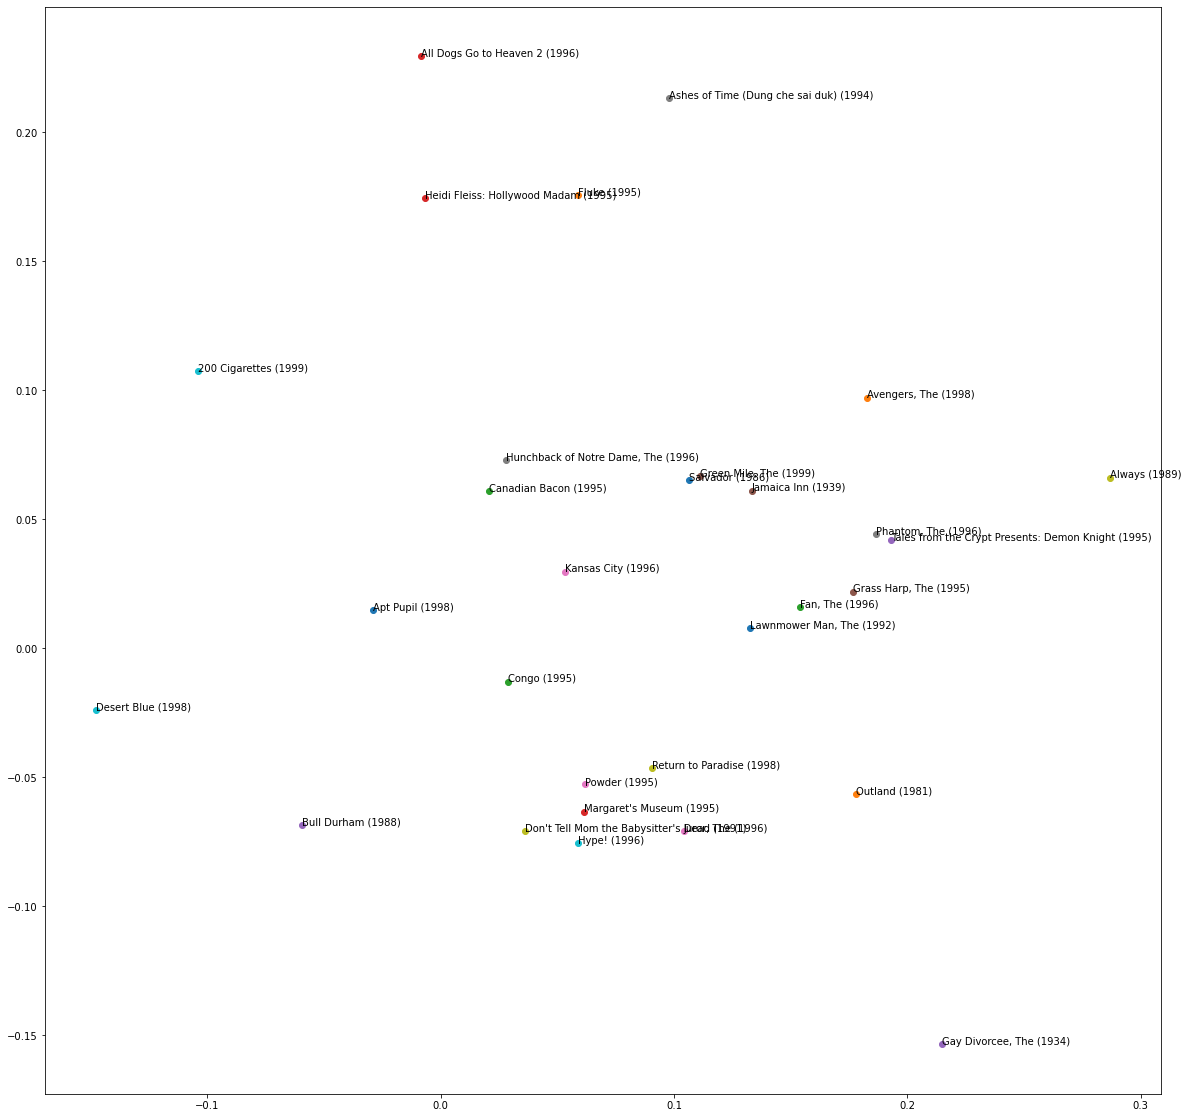

In [125]:
#https://stackoverflow.com/questions/34409600/how-to-calculate-the-mean-of-ratings-of-each-user
#https://git.arts.ac.uk/21035961/Term-2-Data-Science-Assignments/blob/master/Intro%20to%20DS%20-%20Assignment%203/Intro%20to%20DS%20-%20Assignment%203%20-%20Crysern%20Smith.ipynb
#https://www.statology.org/matplotlib-annotate-scatterplot/
#https://stackoverflow.com/questions/56974174/how-to-make-a-loop-for-multiple-scatterplots-in-python
#https://www.codegrepper.com/code-examples/whatever/for+loop+for+multiple+scatter+plots

plt.figure(figsize=(20,20))

for id in mean_ratings_df['MovieID'][:30]:
    plt.scatter(principalComponents[id,0],principalComponents[id,1])
    plt.annotate(movie_data[movie_data["movieId"]==id]["title"].values[0], (principalComponents[id,0],principalComponents[id,1]))

**Conclusion:**
Along with accuracy, novelty and diversity have been highlighted as the key characteristics of meaningful recommendations. There are many ways of defining techniques to improve these qualities and procedures and metrics to judge how effective these techniques are. 
In the above notebook and module, we learnt how these features could help with the quality and accuracy of the recommender.

**References:**

1. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.381.9706&rep=rep1&type=pdf

2. http://ceur-ws.org/Vol-816/divers2011.pdf

3. https://www.researchgate.net/publication/294285905_Novelty_and_Diversity_in_Recommender_Systems

4. https://repositorio.uam.es/bitstream/handle/10486/665149/rank_vargas_recsys_2011_ps.pdf;jsessionid=B9A55C118A18670273D5F4267A2532BE?sequence=1

